In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\umut barış yıldırım\Desktop\mat_407_final_umut_omer_data.csv")

In [3]:
X = df.drop('target', axis=1)
y = df['target']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
def build_generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(output_dim, activation='tanh'))
    return model

In [6]:
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
    return model

In [8]:
def train_gan(gan, generator, discriminator, X_train, epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        # Select a random batch of real data
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        
        # Generate a batch of fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)
        
        # Create labels for real and fake data
        real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing
        fake_labels = np.zeros((batch_size, 1))
        
        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)
        
        # Print the progress
        if epoch % 100 == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

In [9]:
latent_dim = 100
generator = build_generator(latent_dim, X_train.shape[1])
discriminator = build_discriminator(X_train.shape[1])
gan = build_gan(generator, discriminator)
train_gan(gan, generator, discriminator, X_train.values, epochs=1000, batch_size=64, latent_dim=latent_dim)

2/2 [==============================] - 1s 31ms/step
0/1000 [D loss: 30.329771548509598 | D accuracy: 35.15625] [G loss: 0.7729156017303467]
2/2 [==============================] - 0s 9ms/step
100/1000 [D loss: 4.170950457453728 | D accuracy: 50.0] [G loss: 1.2314069271087646]
2/2 [==============================] - 0s 0s/step


2/2 [==============================] - 0s 9ms/step
200/1000 [D loss: 1.8006329834461212 | D accuracy: 50.0] [G loss: 1.5862133502960205]
2/2 [==============================] - 0s 8ms/step
300/1000 [D loss: 1.7251432463526726 | D accuracy: 50.0] [G loss: 1.7808873653411865]
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 16ms/step
400/1000 [D loss: 1.2817078232765198 | D accuracy: 50.0] [G loss: 2.114413261413574]
2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 18ms/step
500/1000 [D loss: 1.0521249659359455 | D accuracy: 50.0] [G loss: 2.264828681945801]
2/2 [==============================] - 0s 18ms/step
600/1000 [D loss: 0.8779846280813217 | D accuracy: 50.0] [G loss: 2.566011905670166]
2/2 [==============================] - 0s 24ms/step


2/2 [==============================] - 0s 18ms/step
700/1000 [D loss: 0.7451016008853912 | D accuracy: 50.0] [G loss: 2.7201361656188965]
2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 21ms/step
800/1000 [D loss: 0.941721810027957 | D accuracy: 50.0] [G loss: 3.041295051574707]
2/2 [==============================] - 0s 0s/step
900/1000 [D loss: 0.7334860172122717 | D accuracy: 50.0] [G loss: 3.156111240386963]
2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 7ms/step


In [10]:
def generate_synthetic_data(generator, num_samples, latent_dim):
    noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data


In [11]:
def prepare_test_data(X_test, synthetic_data, y_test):
    synthetic_labels = np.ones((synthetic_data.shape[0],))
    X_combined = np.vstack((X_test, synthetic_data))
    y_combined = np.concatenate((y_test, synthetic_labels))
    return X_combined, y_combined

In [12]:
num_samples = len(X_test)
synthetic_data = generate_synthetic_data(generator, num_samples, latent_dim)

4/4 [==============================] - 0s 8ms/step


In [13]:
X_combined, y_combined = prepare_test_data(X_test.values, synthetic_data, y_test.values)

In [14]:
X_combined_train, X_combined_val, y_combined_train, y_combined_val = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

In [15]:
class_weight = {0: 1., 1: 10.}

In [16]:
discriminator.fit(X_combined_train, y_combined_train, epochs=1000, batch_size=64, verbose=1, validation_data=(X_combined_val, y_combined_val), class_weight=class_weight)

Epoch 1/1000
4/4 [==============================] - 1s 123ms/step - loss: 17.5705 - accuracy: 0.2154 - val_loss: 1.6656 - val_accuracy: 0.3673
Epoch 2/1000
4/4 [==============================] - 0s 22ms/step - loss: 12.6117 - accuracy: 0.3744 - val_loss: 2.3628 - val_accuracy: 0.2653
Epoch 3/1000
4/4 [==============================] - 0s 19ms/step - loss: 10.7701 - accuracy: 0.2923 - val_loss: 1.2685 - val_accuracy: 0.3469
Epoch 4/1000
4/4 [==============================] - 0s 23ms/step - loss: 10.0914 - accuracy: 0.3949 - val_loss: 1.4572 - val_accuracy: 0.3469
Epoch 5/1000
4/4 [==============================] - 0s 24ms/step - loss: 6.8573 - accuracy: 0.3846 - val_loss: 1.0586 - val_accuracy: 0.4286
Epoch 6/1000
4/4 [==============================] - 0s 22ms/step - loss: 6.0848 - accuracy: 0.4974 - val_loss: 1.7297 - val_accuracy: 0.5714
Epoch 7/1000
4/4 [==============================] - 0s 21ms/step - loss: 6.4101 - accuracy: 0.7026 - val_loss: 2.4388 - val_accuracy: 0.6939
Epoch 8/

Epoch 59/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.8714 - accuracy: 0.8410 - val_loss: 4.1603 - val_accuracy: 0.5714
Epoch 60/1000
4/4 [==============================] - 0s 22ms/step - loss: 6.7220 - accuracy: 0.5590 - val_loss: 1.2518 - val_accuracy: 0.7755
Epoch 61/1000
4/4 [==============================] - 0s 26ms/step - loss: 2.2511 - accuracy: 0.8000 - val_loss: 0.5912 - val_accuracy: 0.9184
Epoch 62/1000
4/4 [==============================] - 0s 28ms/step - loss: 2.0547 - accuracy: 0.8410 - val_loss: 0.8964 - val_accuracy: 0.8571
Epoch 63/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.4409 - accuracy: 0.8769 - val_loss: 0.5333 - val_accuracy: 0.9184
Epoch 64/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.9966 - accuracy: 0.9231 - val_loss: 0.6494 - val_accuracy: 0.8776
Epoch 65/1000
4/4 [==============================] - 0s 18ms/step - loss: 1.6716 - accuracy: 0.8872 - val_loss: 0.4795 - val_accuracy: 0.9388
Epoch 

4/4 [==============================] - 0s 25ms/step - loss: 1.6589 - accuracy: 0.8974 - val_loss: 0.5332 - val_accuracy: 0.9184
Epoch 117/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.9632 - accuracy: 0.9179 - val_loss: 1.8970 - val_accuracy: 0.7143
Epoch 118/1000
4/4 [==============================] - 0s 24ms/step - loss: 3.1630 - accuracy: 0.6667 - val_loss: 1.9384 - val_accuracy: 0.7347
Epoch 119/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.9230 - accuracy: 0.7795 - val_loss: 0.8295 - val_accuracy: 0.8571
Epoch 120/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.1156 - accuracy: 0.8872 - val_loss: 0.6489 - val_accuracy: 0.8776
Epoch 121/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.4124 - accuracy: 0.8718 - val_loss: 0.7552 - val_accuracy: 0.8571
Epoch 122/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.0988 - accuracy: 0.8769 - val_loss: 0.7100 - val_accuracy: 0.8571
Epoch 123/1000

4/4 [==============================] - 0s 22ms/step - loss: 0.7397 - accuracy: 0.8769 - val_loss: 0.5688 - val_accuracy: 0.9184
Epoch 174/1000
4/4 [==============================] - 0s 27ms/step - loss: 1.7904 - accuracy: 0.9026 - val_loss: 0.5573 - val_accuracy: 0.8980
Epoch 175/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.9467 - accuracy: 0.9231 - val_loss: 0.5175 - val_accuracy: 0.8980
Epoch 176/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5802 - accuracy: 0.9128 - val_loss: 0.4376 - val_accuracy: 0.9388
Epoch 177/1000
4/4 [==============================] - 0s 23ms/step - loss: 2.1323 - accuracy: 0.9333 - val_loss: 0.4043 - val_accuracy: 0.9184
Epoch 178/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.7362 - accuracy: 0.9487 - val_loss: 0.4285 - val_accuracy: 0.8776
Epoch 179/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.8237 - accuracy: 0.8462 - val_loss: 0.3813 - val_accuracy: 0.9184
Epoch 180/1000

4/4 [==============================] - 0s 24ms/step - loss: 0.7661 - accuracy: 0.8872 - val_loss: 0.4738 - val_accuracy: 0.8776
Epoch 231/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.8196 - accuracy: 0.8872 - val_loss: 0.4009 - val_accuracy: 0.9184
Epoch 232/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.6175 - accuracy: 0.9333 - val_loss: 0.4357 - val_accuracy: 0.9184
Epoch 233/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.5273 - accuracy: 0.9282 - val_loss: 0.6241 - val_accuracy: 0.8367
Epoch 234/1000
4/4 [==============================] - 0s 25ms/step - loss: 1.2917 - accuracy: 0.8923 - val_loss: 0.7132 - val_accuracy: 0.8367
Epoch 235/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.7322 - accuracy: 0.8923 - val_loss: 0.5816 - val_accuracy: 0.8980
Epoch 236/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.7995 - accuracy: 0.8769 - val_loss: 0.4935 - val_accuracy: 0.9184
Epoch 237/1000

4/4 [==============================] - 0s 21ms/step - loss: 1.3542 - accuracy: 0.9385 - val_loss: 0.4184 - val_accuracy: 0.9184
Epoch 288/1000
4/4 [==============================] - 0s 24ms/step - loss: 1.3147 - accuracy: 0.9231 - val_loss: 0.4205 - val_accuracy: 0.9388
Epoch 289/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.0489 - accuracy: 0.9590 - val_loss: 0.4388 - val_accuracy: 0.9184
Epoch 290/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.8822 - accuracy: 0.9385 - val_loss: 0.4461 - val_accuracy: 0.9184
Epoch 291/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.9550 - accuracy: 0.9436 - val_loss: 0.5071 - val_accuracy: 0.8776
Epoch 292/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.3947 - accuracy: 0.9026 - val_loss: 0.4855 - val_accuracy: 0.8980
Epoch 293/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.5924 - accuracy: 0.9231 - val_loss: 0.4553 - val_accuracy: 0.9184
Epoch 294/1000

4/4 [==============================] - 0s 26ms/step - loss: 0.4287 - accuracy: 0.9333 - val_loss: 0.5548 - val_accuracy: 0.8980
Epoch 345/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.5594 - accuracy: 0.9231 - val_loss: 0.5303 - val_accuracy: 0.8980
Epoch 346/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.5922 - accuracy: 0.9487 - val_loss: 0.5459 - val_accuracy: 0.8776
Epoch 347/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.4988 - accuracy: 0.9077 - val_loss: 0.5105 - val_accuracy: 0.8980
Epoch 348/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.8647 - accuracy: 0.8923 - val_loss: 0.5344 - val_accuracy: 0.8776
Epoch 349/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.9455 - accuracy: 0.9128 - val_loss: 0.5187 - val_accuracy: 0.8776
Epoch 350/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.8134 - accuracy: 0.8923 - val_loss: 0.5484 - val_accuracy: 0.8776
Epoch 351/1000

4/4 [==============================] - 0s 23ms/step - loss: 0.7605 - accuracy: 0.9231 - val_loss: 0.6840 - val_accuracy: 0.8776
Epoch 402/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.8642 - accuracy: 0.9179 - val_loss: 0.6422 - val_accuracy: 0.8980
Epoch 403/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.7639 - accuracy: 0.9487 - val_loss: 0.6372 - val_accuracy: 0.9184
Epoch 404/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.3094 - accuracy: 0.9282 - val_loss: 0.6732 - val_accuracy: 0.9184
Epoch 405/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.5408 - accuracy: 0.9436 - val_loss: 0.6700 - val_accuracy: 0.8980
Epoch 406/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.3954 - accuracy: 0.9538 - val_loss: 0.6570 - val_accuracy: 0.8980
Epoch 407/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.6974 - accuracy: 0.9179 - val_loss: 0.7239 - val_accuracy: 0.8367
Epoch 408/1000

4/4 [==============================] - 0s 24ms/step - loss: 1.2036 - accuracy: 0.8154 - val_loss: 0.7162 - val_accuracy: 0.8776
Epoch 459/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.5836 - accuracy: 0.8718 - val_loss: 0.6215 - val_accuracy: 0.8980
Epoch 460/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.3189 - accuracy: 0.9128 - val_loss: 0.5757 - val_accuracy: 0.8980
Epoch 461/1000
4/4 [==============================] - 0s 27ms/step - loss: 1.7733 - accuracy: 0.9282 - val_loss: 1.4671 - val_accuracy: 0.7959
Epoch 462/1000
4/4 [==============================] - 0s 22ms/step - loss: 2.0774 - accuracy: 0.7590 - val_loss: 2.4379 - val_accuracy: 0.7143
Epoch 463/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.4884 - accuracy: 0.7846 - val_loss: 1.7199 - val_accuracy: 0.8163
Epoch 464/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.1735 - accuracy: 0.8513 - val_loss: 1.2914 - val_accuracy: 0.8367
Epoch 465/1000

4/4 [==============================] - 0s 21ms/step - loss: 0.5515 - accuracy: 0.9436 - val_loss: 0.6167 - val_accuracy: 0.9184
Epoch 516/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.4205 - accuracy: 0.9385 - val_loss: 0.6126 - val_accuracy: 0.8980
Epoch 517/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.3271 - accuracy: 0.9282 - val_loss: 0.8039 - val_accuracy: 0.8776
Epoch 518/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.8152 - accuracy: 0.9077 - val_loss: 0.7719 - val_accuracy: 0.8776
Epoch 519/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5347 - accuracy: 0.9179 - val_loss: 0.7287 - val_accuracy: 0.8776
Epoch 520/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5802 - accuracy: 0.9231 - val_loss: 0.7228 - val_accuracy: 0.8571
Epoch 521/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.4718 - accuracy: 0.9128 - val_loss: 0.6736 - val_accuracy: 0.8980
Epoch 522/1000

4/4 [==============================] - 0s 26ms/step - loss: 1.8623 - accuracy: 0.7641 - val_loss: 0.7494 - val_accuracy: 0.8367
Epoch 573/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.8200 - accuracy: 0.8615 - val_loss: 0.6077 - val_accuracy: 0.8776
Epoch 574/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.5969 - accuracy: 0.9333 - val_loss: 0.6015 - val_accuracy: 0.8776
Epoch 575/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.6152 - accuracy: 0.8872 - val_loss: 0.5675 - val_accuracy: 0.8980
Epoch 576/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.5332 - accuracy: 0.9436 - val_loss: 0.5301 - val_accuracy: 0.9184
Epoch 577/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.0751 - accuracy: 0.9333 - val_loss: 0.5007 - val_accuracy: 0.8980
Epoch 578/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5974 - accuracy: 0.9641 - val_loss: 0.5810 - val_accuracy: 0.8776
Epoch 579/1000

4/4 [==============================] - 0s 25ms/step - loss: 0.5798 - accuracy: 0.9436 - val_loss: 0.4944 - val_accuracy: 0.8980
Epoch 630/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.6436 - accuracy: 0.9436 - val_loss: 0.5241 - val_accuracy: 0.8980
Epoch 631/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.7597 - accuracy: 0.9385 - val_loss: 0.5500 - val_accuracy: 0.8980
Epoch 632/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.4038 - accuracy: 0.9385 - val_loss: 0.5240 - val_accuracy: 0.8980
Epoch 633/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.6680 - accuracy: 0.9231 - val_loss: 0.5329 - val_accuracy: 0.8980
Epoch 634/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.2465 - accuracy: 0.9641 - val_loss: 0.5250 - val_accuracy: 0.8980
Epoch 635/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.1894 - accuracy: 0.9744 - val_loss: 0.5196 - val_accuracy: 0.8980
Epoch 636/1000

4/4 [==============================] - 0s 27ms/step - loss: 0.2531 - accuracy: 0.9436 - val_loss: 0.5708 - val_accuracy: 0.8776
Epoch 687/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.7044 - accuracy: 0.9026 - val_loss: 0.5724 - val_accuracy: 0.8571
Epoch 688/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.2750 - accuracy: 0.9179 - val_loss: 0.5456 - val_accuracy: 0.8980
Epoch 689/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.4099 - accuracy: 0.9436 - val_loss: 0.5320 - val_accuracy: 0.8980
Epoch 690/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.2328 - accuracy: 0.9538 - val_loss: 0.5260 - val_accuracy: 0.8980
Epoch 691/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.2478 - accuracy: 0.9590 - val_loss: 0.5425 - val_accuracy: 0.9184
Epoch 692/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.0668 - accuracy: 0.9385 - val_loss: 0.5047 - val_accuracy: 0.9184
Epoch 693/1000

4/4 [==============================] - 0s 22ms/step - loss: 0.5675 - accuracy: 0.9436 - val_loss: 0.6393 - val_accuracy: 0.8980
Epoch 744/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.3173 - accuracy: 0.9128 - val_loss: 0.6010 - val_accuracy: 0.8980
Epoch 745/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.4012 - accuracy: 0.9538 - val_loss: 0.5863 - val_accuracy: 0.8980
Epoch 746/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.8279 - accuracy: 0.9385 - val_loss: 0.6113 - val_accuracy: 0.8571
Epoch 747/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.5931 - accuracy: 0.9231 - val_loss: 0.5111 - val_accuracy: 0.9184
Epoch 748/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.5065 - accuracy: 0.9436 - val_loss: 0.4822 - val_accuracy: 0.9184
Epoch 749/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.7165 - accuracy: 0.9436 - val_loss: 0.5225 - val_accuracy: 0.8980
Epoch 750/1000

4/4 [==============================] - 0s 23ms/step - loss: 0.2434 - accuracy: 0.9538 - val_loss: 0.5165 - val_accuracy: 0.8980
Epoch 801/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5021 - accuracy: 0.9231 - val_loss: 0.5405 - val_accuracy: 0.8980
Epoch 802/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.4180 - accuracy: 0.9385 - val_loss: 0.5239 - val_accuracy: 0.8980
Epoch 803/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.1676 - accuracy: 0.9692 - val_loss: 0.5211 - val_accuracy: 0.9184
Epoch 804/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.2529 - accuracy: 0.9538 - val_loss: 0.5148 - val_accuracy: 0.9184
Epoch 805/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.9816 - accuracy: 0.9846 - val_loss: 0.5582 - val_accuracy: 0.8980
Epoch 806/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.4042 - accuracy: 0.9128 - val_loss: 0.7102 - val_accuracy: 0.8571
Epoch 807/1000

4/4 [==============================] - 0s 27ms/step - loss: 0.3176 - accuracy: 0.9436 - val_loss: 0.5440 - val_accuracy: 0.9388
Epoch 858/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.5037 - accuracy: 0.9487 - val_loss: 0.5496 - val_accuracy: 0.8980
Epoch 859/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.2555 - accuracy: 0.9385 - val_loss: 0.5457 - val_accuracy: 0.8980
Epoch 860/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.1307 - accuracy: 0.9487 - val_loss: 0.5417 - val_accuracy: 0.9184
Epoch 861/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.3755 - accuracy: 0.9333 - val_loss: 0.5225 - val_accuracy: 0.8980
Epoch 862/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.1774 - accuracy: 0.9538 - val_loss: 0.5133 - val_accuracy: 0.9184
Epoch 863/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.1957 - accuracy: 0.9692 - val_loss: 0.5093 - val_accuracy: 0.9184
Epoch 864/1000

4/4 [==============================] - 0s 22ms/step - loss: 0.2227 - accuracy: 0.9436 - val_loss: 0.6302 - val_accuracy: 0.8980
Epoch 915/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.6981 - accuracy: 0.9436 - val_loss: 0.7017 - val_accuracy: 0.8776
Epoch 916/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.2696 - accuracy: 0.9487 - val_loss: 0.6905 - val_accuracy: 0.8776
Epoch 917/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.2038 - accuracy: 0.9538 - val_loss: 0.7032 - val_accuracy: 0.8980
Epoch 918/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.2199 - accuracy: 0.9538 - val_loss: 0.6920 - val_accuracy: 0.8980
Epoch 919/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.4051 - accuracy: 0.9487 - val_loss: 0.6591 - val_accuracy: 0.8980
Epoch 920/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.1798 - accuracy: 0.9487 - val_loss: 0.6399 - val_accuracy: 0.9184
Epoch 921/1000

4/4 [==============================] - 0s 25ms/step - loss: 0.2920 - accuracy: 0.9538 - val_loss: 0.6599 - val_accuracy: 0.9184
Epoch 972/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.2237 - accuracy: 0.9692 - val_loss: 0.6624 - val_accuracy: 0.8776
Epoch 973/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.4665 - accuracy: 0.9128 - val_loss: 0.5949 - val_accuracy: 0.8776
Epoch 974/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.4221 - accuracy: 0.9436 - val_loss: 0.5523 - val_accuracy: 0.8980
Epoch 975/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.1718 - accuracy: 0.9487 - val_loss: 0.5487 - val_accuracy: 0.9184
Epoch 976/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.1812 - accuracy: 0.9590 - val_loss: 0.6177 - val_accuracy: 0.9388
Epoch 977/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.8028 - accuracy: 0.9538 - val_loss: 0.6905 - val_accuracy: 0.8980
Epoch 978/1000

In [17]:
y_pred_test = (discriminator.predict(X_test.values) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_test, zero_division=0))

4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       112
           1       0.50      0.80      0.62        10

    accuracy                           0.92       122
   macro avg       0.74      0.86      0.78       122
weighted avg       0.94      0.92      0.93       122



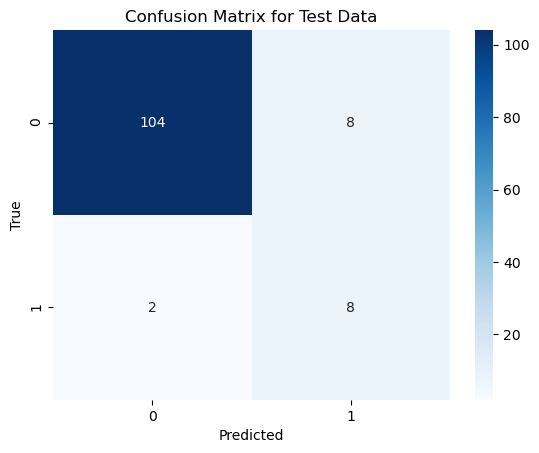

In [18]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Data')
plt.show()